# Counting Boats from Space - Part 2

In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
%matplotlib inline

## 1. Install, Import requirements

In [2]:
# Various utilities
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import torch
from torch.utils.data import DataLoader
import superintendent

In [3]:
from src.dataset import getImageSetDirectories, S2_Dataset, plot_dataset
from src.model import Model
from src.train import train, get_failures_or_success
from src.annotation_utils import display_image_and_references, display_heatmap_prediction

In [4]:
torch.cuda.is_available() # gpu support

True

## 2. Init Dataset

In [5]:
data_dir = "/home/jovyan/data" # data directory (path)
labels_dir = './data'
checkpoint_dir = "/home/jovyan/checkpoints"
bands = ['img_08', 'bg_ndwi', 'img_clp']
test_size = 0.1

Found 95 coordinates:85 train / 10 val
Assertion error 1 3 ['/home/jovyan/data/chips/lat_44_835_lon_20_645/bg_ndwi.png']


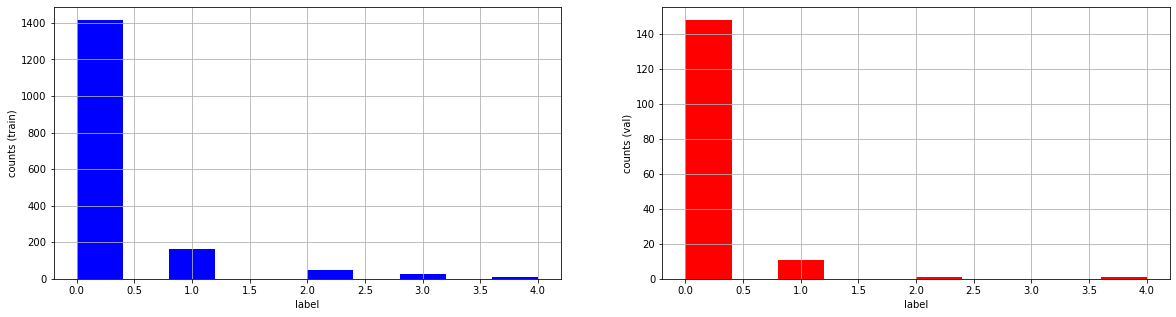

In [6]:
train_list, val_list, fig = getImageSetDirectories(data_dir=os.path.join(data_dir, 'chips'), 
                                                   labels_filename=os.path.join(labels_dir, "labels.csv"),
                                                   band_list=bands, test_size=test_size, plot_coords=False, plot_class_imbalance=True, seed=123)
fig # mapbox plot train/val coordinates

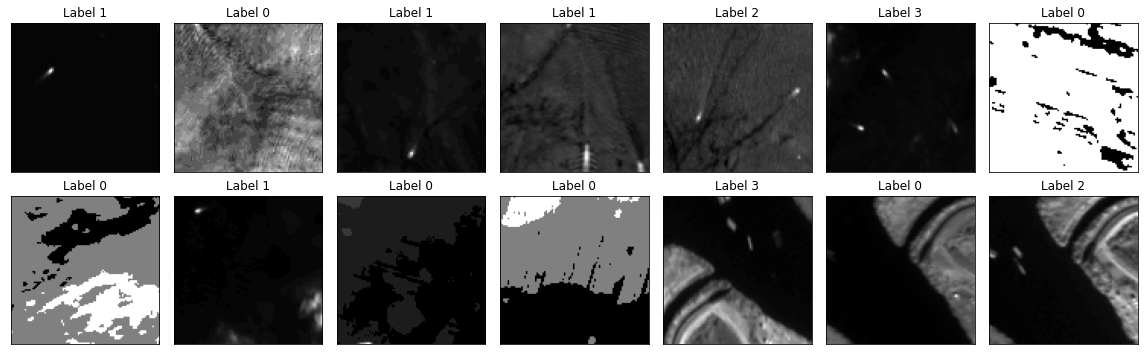

In [7]:
train_dataset = S2_Dataset(imset_dir=train_list, augment=True, labels_filename=os.path.join(labels_dir,'labels.csv'))
val_dataset = S2_Dataset(imset_dir=val_list, augment=False, labels_filename=os.path.join(labels_dir,'labels.csv'))
plot_dataset(train_dataset, n_frames=14, n_rows=2, cmap='gray')

## 3. Train PyTorch Classifier

In [8]:
# training config
input_dim = train_dataset[0]['img'].shape[0]
hidden_dim, kernel_size, pool_size, n_max = 32, 3, 10, 1

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=16)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

best_metrics = train(train_dataloader=train_dataloader, val_dataloader=val_dataloader,
             input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, pool_size=pool_size, n_max=n_max, drop_proba=0.10,
             ld=0.5, water_ndwi=-1.0,
             n_epochs=150, lr=0.004, lr_step=2, lr_decay=0.95,
             device='cuda:0', checkpoints_dir=checkpoint_dir, seed=42, verbose=1, version='0.0.6_NIR_BGNDWI')

for k,v in best_metrics.items():
    print('{} {:.4f}'.format(k,v))

In [ ]:
###  [NIR, BG NDWI, CLP, h=32]  ###
## Epoch 131: train_clf_error 0.03189 / train_reg_error 0.02855 / val_clf_error 0.00621 / val_reg_error 0.00637
## train_accuracy 0.9861 / train_precision 0.9875 / train_recall 0.9449 / train_f1 0.9427 / val_accuracy 1.0000 / val_precision 1.0000 / val_recall 1.0000 / val_f1 1.0000
## train_MAE 0.049 / val_MAE 0.018 [water_ndwi=-1.0, filter_peaks(d=2, abs=0.25, rel0.9), downsample(10)]

###  [NIR, BG NDWI, h=16]  ###
## Epoch 101: train_clf_error 0.0409 / train_reg_error 0.0356 / val_clf_error 0.0157 / val_reg_error 0.0058
## train_accuracy 0.9807 / train_precision 0.9735 /train_recall 0.9325 / train_f1 0.9238 / val_accuracy 0.9938  / val_precision 1.0000 / val_recall 0.9938 / val_f1 0.9938
## train_MAE 0.071 / val_MAE 0.023 [water_ndwi=-1.0, filter_peaks(d=2, abs=0.25, rel0.9), downsample(10)]

###  [NIR, Green, h=16]  ###
## Epoch 68: train_clf_error 0.11828 / train_reg_error 0.05201 / val_clf_error 0.06706 / val_reg_error 0.02426
## train_accuracy 0.9499 / train_precision 0.9132 /train_recall 0.8207 / train_f1 0.7781 / val_accuracy 0.9814  / val_precision 0.9876 / val_recall 0.9938 / val_f1 0.9814
## train_MAE 0.107 / val_MAE 0.057 [water_ndwi=-1.0, filter_peaks(d=2, abs=0.25, rel0.9), downsample(10)]

###  [NIR, h=16]  ###
## Epoch 137: train_clf_error 0.14076 / train_reg_error 0.04668 / val_clf_error 0.08439 / val_reg_error 0.03653
## train_accuracy 0.9487 / train_precision 0.9192 /train_recall 0.8402 / train_f1 0.8078 / val_accuracy 0.9503  / val_precision 0.9689 / val_recall 0.9814 / val_f1 0.9503
## train_MAE 0.106 / val_MAE 0.063 [water_ndwi=-1.0, filter_peaks(d=2, abs=0.25, rel0.9), downsample(10)]

## 4. Test Model

In [9]:
# load pretrained model
model = Model(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, pool_size=pool_size, n_max=n_max, device='cuda:0', version='0.0.6_NIR_BGNDWI')
checkpoint_file = os.path.join(checkpoint_dir, model.folder, 'model.pth')
model.load_checkpoint(checkpoint_file=checkpoint_file)
model = model.eval()

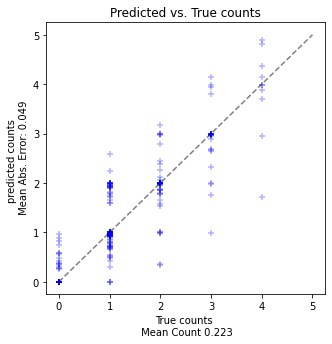

In [17]:
# Display failures (train, val), scatter plot (Predicted vs True) and inspect hidden channels --> Re label?
image_titles, relabel_images = get_failures_or_success(model, train_dataset, success=None, filter_on=None,
                                                       water_ndwi=-1.0, filter_peaks=True, downsample=True,  # filter_peaks and/or downsample
                                                       plot_heatmap=False, hidden_channel=1,)

## 5. Relabel inputs

### Load superintendent widget and labelling

In [ ]:
csv_file_path = "/home/jovyan/data/labels.csv"
labels_df = pd.read_csv(csv_file_path, index_col = ['lat_lon', 'timestamp'], dtype={'count': float})

labeller = superintendent.ClassLabeller(
    features=image_titles,
    options=[i for i in range(-1, 6)], 
    display_func=display_heatmap_prediction
)

#labeller

### Extract new labels and save them in labels_df

In [ ]:
for i in range(len(relabel_images)):
    timestamp = relabel_images[i].stem.split('t_')[1]
    lat_lon = relabel_images[i].parts[-2]
    count = labeller.new_labels[i]
    # overwrite if the 
    if count:
        labels_df.at[(lat_lon, timestamp)] = count

### Dump back to csv file

In [ ]:
#labels_df.to_csv(csv_file_path)